# SAM: Inference Playground

In [ ]:
# os.chdir(f'./{CODE_DIR}')

In [1]:
from argparse import Namespace
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from datasets.augmentations import AgeTransformer
from utils.common import tensor2im
from models.psp import pSp

In [2]:
EXPERIMENT_TYPE = 'ffhq_aging'

## Step 1: Download Pretrained Model
As part of this repository, we provide our pretrained aging model.
We'll download the model for the selected experiments as save it to the folder `../pretrained_models`.

## Step 2: Define Inference Parameters

Below we have a dictionary defining parameters such as the path to the pretrained model to use and the path to the
image to perform inference on.
While we provide default values to run this script, feel free to change as needed.

In [3]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_aging": {
        "model_path": "../pretrained_models/sam_ffhq_aging.pt",
        "image_path": "./images/ma.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

In [4]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]

## Step 3: Load Pretrained Model
We assume that you have downloaded the pretrained aging model and placed it in the path defined above

In [5]:
# model_path = EXPERIMENT_ARGS['model_path']
model_path = EXPERIMENT_ARGS['model_path']

ckpt = torch.load(model_path, map_location='cpu')

In [6]:
opts = ckpt['opts']
pprint.pprint(opts)

{'aging_lambda': 5.0,
 'batch_size': 6,
 'board_interval': 50,
 'checkpoint_path': None,
 'cycle_lambda': 1.0,
 'dataset_type': 'ffhq_aging',
 'device': 'cuda',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 4,
 'l2_lambda': 0.25,
 'l2_lambda_aging': 0.25,
 'l2_lambda_crop': 1.0,
 'label_nc': 0,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.1,
 'lpips_lambda_aging': 0.1,
 'lpips_lambda_crop': 0.6,
 'max_steps': 500000,
 'optim_name': 'ranger',
 'output_size': 1024,
 'pretrained_psp_path': '',
 'save_interval': 2500,
 'start_from_encoded_w_plus': True,
 'start_from_latent_avg': False,
 'stylegan_weights': '',
 'target_age': 'uniform_random',
 'test_batch_size': 6,
 'test_workers': 6,
 'train_decoder': False,
 'use_weighted_id_loss': True,
 'val_interval': 2500,
 'w_norm_lambda': 0.005,
 'workers': 6}


In [7]:
# update the training options
opts['checkpoint_path'] = model_path

In [8]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading SAM from checkpoint: ../pretrained_models/sam_ffhq_aging.pt
Model successfully loaded!


## Step 4: Visualize Input

In [9]:
image_path = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]["image_path"]
original_image = Image.open(image_path).convert("RGB")

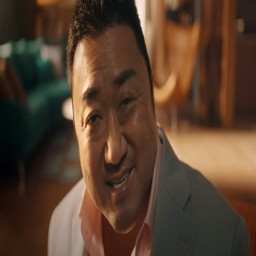

In [10]:
original_image.resize((256, 256))

## Step 5: Perform Inference

### Align Image

Before running inference we'll run alignment on the input image.

In [5]:
def run_alignment(image_path):
    import dlib
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor) 
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image 

In [6]:
aligned_image = run_alignment(image_path)

NameError: name 'image_path' is not defined

In [2]:
aligned_image.resize((256, 256))

NameError: name 'aligned_image' is not defined

### Run Inference

In [1]:
img_transforms = EXPERIMENT_ARGS['transform']
input_image = img_transforms(aligned_image)

NameError: name 'EXPERIMENT_ARGS' is not defined

In [2]:
# we'll run the image on multiple target ages 
# target_ages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
target_ages = [0, 10, 20, 30, 40, 50, 60]
age_transformers = [AgeTransformer(target_age=age) for age in target_ages]

NameError: name 'AgeTransformer' is not defined

In [ ]:
def run_on_batch(inputs, net):
    result_batch = net(inputs.to("cuda").float(), randomize_noise=False, resize=False)
    return result_batch

In [ ]:
# for each age transformed age, we'll concatenate the results to display them side-by-side
results = np.array(aligned_image.resize((1024, 1024)))
for age_transformer in age_transformers:
    print(f"Running on target age: {age_transformer.target_age}")
    with torch.no_grad():
        input_image_age = [age_transformer(input_image.cpu()).to('cuda')]
        input_image_age = torch.stack(input_image_age)
        result_tensor = run_on_batch(input_image_age, net)[0]
        result_image = tensor2im(result_tensor)
        results = np.concatenate([results, result_image], axis=1)

### Visualize Result

In [ ]:
results = Image.fromarray(results)
results   # this is a very large image (11*1024 x 1024) so it may take some time to display!

In [ ]:
# save image at full resolution
results.save("notebooks/images/age_transformed_image.jpg")